# Explore wrangled TRI data

Now that I have wrangled the TRI data into a usable format, I want to explore the data further to find some interesting case studies. I am most interested in the RSEI scores. I want to find out if there are areas with higher RSEI scores than others, and also explore which chemicals may be causing the most harm and if these are concentrated anywhere.

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
from functools import reduce

# supress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# read tri data in
tri_in = gpd.read_file('../data/tri-facilities.geojson')

In [3]:
# create a copy to revert back to if necessary
tri = tri_in.copy()
tri.head()

,TRIFID,YEAR,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,BIA,TRIBE,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,CHEMICAL,PARENT_CO_NAME,RSEI_SCORE,RSEI_FACILITY_REPORT,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER,geometry
0,00608DCRBNRD3KM,2018,IDI CARIBE INC,PR3 KM 151.8 AGUIRRE,SALINAS,SALINAS,PR,751,,,17.97278,-66.23194,Chemicals,"ZINC COMPOUNDS, STYRENE",,2.03719,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,2.03719,POINT (-66.23194 17.97278)
1,0060WHPNTRCARR1,2018,HP INTERNATIONAL TRADING BV (PUERTO RICO BRANC...,"CARR 110, KM. 5.1",AGUADILLA,AGUADILLA,PR,603,,,18.45647,-67.13655,Chemicals,CERTAIN GLYCOL ETHERS,HP INC,1.76193,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,1.76193,POINT (-67.13655 18.45647)
2,00610BXTRHROAD4,2018,EDWARDS LIFESCIENCES TECHNOLOGY SARL,STATE RD 402 KM 1.4 N LAS MARIAS IND US TRIAL ...,ANASCO,ANASCO,PR,610,,,18.29298,-67.13682,Miscellaneous Manufacturing,"ETHYLENE OXIDE, ETHYLENE GLYCOL",EDWARDS LIFESCIENCES LLC,901403.70000,https://enviro.epa.gov/enviro/rsei.html?facid=...,901403.70000,9.83350,POINT (-67.13682 18.29298)
3,00610CRBGNCARR4,2018,GE INTERNATIONAL OF PR LLC,STATE RD 402 KM 1.5 INDUSTRIAL ZONE,ANASCO,ANASCO,PR,610,,,18.29244,-67.14019,Electrical Equipment,LEAD,GENERAL ELECTRIC CO (GE CO),0.43420,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,0.43420,POINT (-67.14019 18.29244)
4,00612PRPCMPR681,2018,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,PR-681 KM 0.5,ARECIBO,ARECIBO,PR,612,,,18.47110,-66.69940,Electric Utilities,"NAPHTHALENE, POLYCYCLIC AROMATIC COMPOUNDS",PUERTO RICO ELECTRIC POWER AUTHORITY,55.56060,https://enviro.epa.gov/enviro/rsei.html?facid=...,55.56060,0.00000,POINT (-66.69940 18.47110)


## RSEI score by media release

I want to join this table to the TRI facility geojson, with a RSEI water score, and a total RSEI air score.

In [7]:
# read media release table in
media = pd.read_excel('../data/rsei-tables/2018-rsei-scores-by-media.xlsx')
media

,SubmissionYear,FacilityID,RSEI Score,RSEI Media
0,2018,0060WHPNTRCARR1,1.15774,Stack Air Releases
1,2018,0060WHPNTRCARR1,0.60419,Fugitive Air Releases
2,2018,0061WMPRTRSTATE,9.72055,Stack Air Releases
3,2018,0061WMPRTRSTATE,7.46333,Fugitive Air Releases
4,2018,0062WPRTRCCARRE,7981.64000,Fugitive Air Releases
...,...,...,...,...
28027,2018,155524GYSN23IND,46982.70000,Fugitive Air Releases
28028,2018,275593MCPT4191H,2.48068,Fugitive Air Releases
28029,2018,275593MCPT4191H,1.27533,Stack Air Releases
28030,2018,688181FBRG1318W,0.22918,Stack Air Releases


In [19]:
# first select records by both air release type
air = media.loc[(media['RSEI Media'] == 'Stack Air Releases') | (media['RSEI Media'] == 'Fugitive Air Releases')]
air

,SubmissionYear,FacilityID,RSEI Score,RSEI Media
0,2018,0060WHPNTRCARR1,1.15774,Stack Air Releases
1,2018,0060WHPNTRCARR1,0.60419,Fugitive Air Releases
2,2018,0061WMPRTRSTATE,9.72055,Stack Air Releases
3,2018,0061WMPRTRSTATE,7.46333,Fugitive Air Releases
4,2018,0062WPRTRCCARRE,7981.64000,Fugitive Air Releases
...,...,...,...,...
28027,2018,155524GYSN23IND,46982.70000,Fugitive Air Releases
28028,2018,275593MCPT4191H,2.48068,Fugitive Air Releases
28029,2018,275593MCPT4191H,1.27533,Stack Air Releases
28030,2018,688181FBRG1318W,0.22918,Stack Air Releases


In [20]:
# and reduce into one record with combined RSEI air release score
air = air.fillna('').groupby('FacilityID').agg({ 'RSEI Score':'sum'}).reset_index()

air = air.rename(columns={'RSEI Score': 'RSEI_air_release_score',
                         'FacilityID': 'TRIFID'})

air

,TRIFID,RSEI_air_release_score
0,00608DCRBNRD3KM,2.03719
1,0060WHPNTRCARR1,1.76193
2,00610BXTRHROAD4,901403.70000
3,00610CRBGNCARR4,0.43420
4,00612PRPCMPR681,55.56060
...,...,...
15515,9974WSBLLC1RIVE,0.00506
15516,99752RDDGP90MIL,2172.04828
15517,99801CRLSK331CL,0.03530
15518,99801KNNCT13401,779.09962


In [23]:
# select records with water release
water = media.loc[(media['RSEI Media'] == 'Direct Water Releases')]
water

,SubmissionYear,FacilityID,RSEI Score,RSEI Media
54,2018,0272WTPCMP63WAT,0.00002,Direct Water Releases
55,2018,0276WLDCST41ALM,14.47339,Direct Water Releases
62,2018,0288WTPCMP373BM,0.01110,Direct Water Releases
68,2018,0291WSPRGS1DEXT,0.01302,Direct Water Releases
103,2018,0441WWBBRT93RIV,0.00000,Direct Water Releases
...,...,...,...,...
28014,2018,99737PGMNX38MIL,0.00000,Direct Water Releases
28016,2018,99743HLYPW25MIL,0.00000,Direct Water Releases
28019,2018,99752RDDGP90MIL,0.00000,Direct Water Releases
28022,2018,99801CRLSK331CL,0.00000,Direct Water Releases


In [24]:
# filter columns to eliminate ones I don't need
water = water.filter(['FacilityID', 'RSEI Score'])

# rename RSEI score to reflect score by water release
water = water.rename(columns={'RSEI Score': 'RSEI_water_release_score',
                             'FacilityID': 'TRIFID'})

water

,TRIFID,RSEI_water_release_score
54,0272WTPCMP63WAT,0.00002
55,0276WLDCST41ALM,14.47339
62,0288WTPCMP373BM,0.01110
68,0291WSPRGS1DEXT,0.01302
103,0441WWBBRT93RIV,0.00000
...,...,...
28014,99737PGMNX38MIL,0.00000
28016,99743HLYPW25MIL,0.00000
28019,99752RDDGP90MIL,0.00000
28022,99801CRLSK331CL,0.00000


In [31]:
# now join scores by release type back to facility geojson

# create list of tri and rsei score dataframes to be merged
data_frames = [tri, air, water]

# join list of dataframes
tri_joined = reduce(lambda left,right: pd.merge(left,right,on=['TRIFID'],
                                            how='outer'), data_frames)

# inspect results
tri_joined

,TRIFID,YEAR,FACILITY_NAME,STREET_ADDRESS,CITY,COUNTY,ST,ZIP,BIA,TRIBE,...,INDUSTRY_SECTOR,CHEMICAL,PARENT_CO_NAME,RSEI_SCORE,RSEI_FACILITY_REPORT,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER,geometry,RSEI_air_release_score,RSEI_water_release_score
0,00608DCRBNRD3KM,2018,IDI CARIBE INC,PR3 KM 151.8 AGUIRRE,SALINAS,SALINAS,PR,751,,,...,Chemicals,"ZINC COMPOUNDS, STYRENE",,2.03719,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,2.03719,POINT (-66.23194 17.97278),2.03719,nan
1,0060WHPNTRCARR1,2018,HP INTERNATIONAL TRADING BV (PUERTO RICO BRANC...,"CARR 110, KM. 5.1",AGUADILLA,AGUADILLA,PR,603,,,...,Chemicals,CERTAIN GLYCOL ETHERS,HP INC,1.76193,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,1.76193,POINT (-67.13655 18.45647),1.76193,nan
2,00610BXTRHROAD4,2018,EDWARDS LIFESCIENCES TECHNOLOGY SARL,STATE RD 402 KM 1.4 N LAS MARIAS IND US TRIAL ...,ANASCO,ANASCO,PR,610,,,...,Miscellaneous Manufacturing,"ETHYLENE OXIDE, ETHYLENE GLYCOL",EDWARDS LIFESCIENCES LLC,901403.70000,https://enviro.epa.gov/enviro/rsei.html?facid=...,901403.70000,9.83350,POINT (-67.13682 18.29298),901403.70000,nan
3,00610CRBGNCARR4,2018,GE INTERNATIONAL OF PR LLC,STATE RD 402 KM 1.5 INDUSTRIAL ZONE,ANASCO,ANASCO,PR,610,,,...,Electrical Equipment,LEAD,GENERAL ELECTRIC CO (GE CO),0.43420,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,0.43420,POINT (-67.14019 18.29244),0.43420,nan
4,00612PRPCMPR681,2018,PREPA-CAMBALACHE COMBUSTION TURBINE PLANT,PR-681 KM 0.5,ARECIBO,ARECIBO,PR,612,,,...,Electric Utilities,"NAPHTHALENE, POLYCYCLIC AROMATIC COMPOUNDS",PUERTO RICO ELECTRIC POWER AUTHORITY,55.56060,https://enviro.epa.gov/enviro/rsei.html?facid=...,55.56060,0.00000,POINT (-66.69940 18.47110),55.56060,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21552,9974WSBLLC1RIVE,2018,USIBELLI COAL MINE INC,100 RIVER ROAD,HEALY,DENALI,AK,99743,,,...,Coal Mining,"LEAD and LEAD COMPOUNDS, MANGANESE and MANGA...",,0.00506,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.00000,0.00506,POINT (-148.68056 63.91775),0.00506,nan
21553,99752RDDGP90MIL,2018,RED DOG OPERATIONS,90 MILES N OF KOTZEBUE,KOTZEBUE,NORTHWEST ARCTIC BOROUGH,AK,99752,,,...,Metal Mining,"LEAD COMPOUNDS, 1,2,4-TRIMETHYLBENZENE, METHAN...",TECK AMERICAN INC,2172.04828,https://enviro.epa.gov/enviro/rsei.html?facid=...,1911.68673,347.79365,POINT (-162.85549 68.06151),2172.04828,0.00000
21554,99801CRLSK331CL,2018,COEUR ALASKA INC KENSINGTON GOLD PROJECT,3031 CLINTON DR,JUNEAU,JUNEAU BOROUGH,AK,99801,,,...,Metal Mining,"MERCURY COMPOUNDS, PROPYLENE, COPPER and COPP...",COEUR MINING INC.,0.05632,https://enviro.epa.gov/enviro/rsei.html?facid=...,0.05310,0.00581,POINT (-135.10476 58.86749),0.03530,0.00000
21555,99801KNNCT13401,2018,HECLA GREENS CREEK MINING CO,13401 GLACIER HWY,JUNEAU,JUNEAU BOROUGH,AK,99801,,,...,Metal Mining,"1,2,4-TRIMETHYLBENZENE, MANGANESE, CADMIUM COM...",HECLA MINING CO,779.09962,https://enviro.epa.gov/enviro/rsei.html?facid=...,772.92510,18.02604,POINT (-134.64121 58.08180),779.09962,0.00000


In [33]:
# create new files for air releasing and water releasing facilities for further exploration in QGIS
air_facilities = tri_joined.loc[tri_joined['RSEI_air_release_score'].notnull()]
water_facilities = tri_joined.loc[tri_joined['RSEI_water_release_score'].notnull()]

air_facilities.to_file("../data/air-scores.geojson", driver='GeoJSON', encoding='utf-8')
water_facilities.to_file("../data/water-scores.geojson", driver='GeoJSON', encoding='utf-8')

In [4]:
tri['TRIBE'].value_counts()

                                                                                                                 21514
Puyallup Tribe of the Puyallup Reservation                                                                          10
Gila River Indian Community of the Gila River Indian Reservation, Arizona                                            8
Oneida Tribe of Indians of Wisconsin                                                                                 4
Confederated Tribes and Bands of the Yakama Nation                                                                   3
Navajo Nation, Arizona, New Mexico & Utah                                                                            2
Choctaw Nation of Oklahoma                                                                                           2
Coeur D'Alene Tribe (previously listed as the Coeur D'Alene Tribe of the Coeur D'Alene Reservation, Idaho)           2
Colorado River Indian Tribes of the Colorado Riv

## Explore TRI counts and RSEI scores by state

The RSEI scores are designed as a ranking system, to compare one facility to another in terms of the risk posed. These scores can also be compared across geographic regions. So first I am going to count the total facilities per state, and then calculate the total RSEI scores by state.

In [4]:
# find total number of tri sites per state
tri_state_counts = tri['ST'].value_counts().rename_axis('state').reset_index(name='TRI_COUNT')
tri_state_counts

,state,TRI_COUNT
0,TX,1796
1,OH,1315
2,CA,1208
3,PA,1112
4,IL,1031
5,IN,902
6,WI,852
7,NC,779
8,MI,758
9,GA,697


In [5]:
# find total RSEI scores per state
for first_index, first_row in tri_state_counts.iterrows():
    scores = []
    cancer_scores = []
    non_cancer = []
    for second_index, second_row in tri.iterrows():
        if first_row['state'] == second_row['ST']:
            scores.append(second_row['RSEI_SCORE'])
            cancer_scores.append(second_row['RSEI_SCORE_CANCER'])
            non_cancer.append(second_row['RSEI_SCORE_NONCANCER'])

    # assign total scores per state to new column
    tri_state_counts.at[first_index, 'RSEI_SCORE'] = sum(scores)
    tri_state_counts.at[first_index, 'RSEI_SCORE_CANCER'] = sum(cancer_scores)
    tri_state_counts.at[first_index, 'RSEI_SCORE_NONCANCER'] = sum(non_cancer)
    
tri_state_counts.sample(10)

,state,TRI_COUNT,RSEI_SCORE,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER
43,ND,77,213988.75841,90633.72447,25416.64431
8,MI,758,9037527.48356,8829459.10982,229681.94460
22,LA,372,18562002.58627,18139829.14852,416497.68966
12,TN,606,12838151.93589,12280599.64682,370127.59680
6,WI,852,4334902.63153,4091482.37623,257624.59377
14,SC,523,5334061.02603,5158893.31083,169137.84522
38,NH,117,24246.03979,22276.86508,2017.24208
52,GU,9,1106.32279,651.67827,481.82642
46,DE,60,5383061.40599,5368642.24521,14759.39517
25,WA,320,5939646.50604,5822644.35449,137966.37080


In [13]:
# read states shapefile in
states_in = gpd.read_file('../data/state-shapefile/tl_2019_us_state.shp')
states_in.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


In [14]:
# join TRI counts and scores to state data
states = pd.merge(states_in, tri_state_counts, left_on='STUSPS', right_on='state', how='left')
states

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,TRI_COUNT,RSEI_SCORE,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,170,6000828.46595,5931097.89857,82291.48331
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ...",FL,684,65987701.84407,63037651.32807,3146563.22653
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",IL,1031,21509430.61477,20561394.52585,1014472.68820
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",MN,508,1983604.98458,1843727.44455,188166.19086
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",MD,161,686848.03420,618722.92943,76335.81453
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677787140,1323663210,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.78970 41.72520, -71.78971 ...",RI,81,48022.16092,45287.16020,3145.46613
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,214049897859,2391604238,+44.3484222,-114.5588538,"POLYGON ((-116.89971 44.84061, -116.89967 44.8...",ID,117,85869.83776,75171.50643,11474.83643
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,23189198255,1026903434,+43.6726907,-071.5843145,"POLYGON ((-72.32990 43.60021, -72.32984 43.600...",NH,117,24246.03979,22276.86508,2017.24208
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,125925929633,13463401534,+35.5397100,-079.1308636,"POLYGON ((-82.41674 36.07283, -82.41660 36.073...",NC,779,7262547.38546,6964165.29896,314736.45445
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,23874197924,1030383955,+44.0685773,-072.6691839,"POLYGON ((-73.31328 44.26413, -73.31274 44.265...",VT,37,316.94724,228.36318,89.38387


In [15]:
list(states.columns)

['REGION',
 'DIVISION',
 'STATEFP',
 'STATENS',
 'GEOID',
 'STUSPS',
 'NAME',
 'LSAD',
 'MTFCC',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'geometry',
 'state',
 'TRI_COUNT',
 'RSEI_SCORE',
 'RSEI_SCORE_CANCER',
 'RSEI_SCORE_NONCANCER']

In [16]:
# filter to only keep the fields I need
states = states.filter(['GEOID', 'STUSPS', 'NAME', 'ALAND', 'geometry', 'id', 'TRI_COUNT', 'RSEI_SCORE', 'RSEI_SCORE_CANCER', 'RSEI_SCORE_NONCANCER'])
states.head()

,GEOID,STUSPS,NAME,ALAND,geometry,TRI_COUNT,RSEI_SCORE,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER
0,54,WV,West Virginia,62266231560,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",170,6000828.46595,5931097.89857,82291.48331
1,12,FL,Florida,138947364717,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ...",684,65987701.84407,63037651.32807,3146563.22653
2,17,IL,Illinois,143779863817,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",1031,21509430.61477,20561394.52585,1014472.68820
3,27,MN,Minnesota,206230065476,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",508,1983604.98458,1843727.44455,188166.19086
4,24,MD,Maryland,25151726296,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",161,686848.03420,618722.92943,76335.81453


I am going to use the land area for each state to find number of sites per square mile. This will give a better indication of where sites are more densely located than just going with the raw count.

In [17]:
# convert land area from square meters to square miles
states['ALAND_square_miles'] = states['ALAND'] / 2589988.110336

# calculate tri facilities per square mile
states['TRI_DENSITY'] = states['TRI_COUNT']/states['ALAND_square_miles']

states.head()

,GEOID,STUSPS,NAME,ALAND,geometry,TRI_COUNT,RSEI_SCORE,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER,ALAND_square_miles,TRI_DENSITY
0,54,WV,West Virginia,62266231560,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",170,6000828.46595,5931097.89857,82291.48331,24041.12641,0.00707
1,12,FL,Florida,138947364717,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ...",684,65987701.84407,63037651.32807,3146563.22653,53647.87744,0.01275
2,17,IL,Illinois,143779863817,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",1031,21509430.61477,20561394.52585,1014472.68820,55513.71577,0.01857
3,27,MN,Minnesota,206230065476,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",508,1983604.98458,1843727.44455,188166.19086,79625.87344,0.00638
4,24,MD,Maryland,25151726296,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",161,686848.03420,618722.92943,76335.81453,9711.13581,0.01658


Let's see which states rank highest for the categories I just calculated.

In [18]:
# which states have the highest density of TRI facilities
# DC has the most, but its area is very small
# followed by Rhode Island, Connecticut, and Massachusetts
states.sort_values(['TRI_DENSITY'], ascending=False).head()

,GEOID,STUSPS,NAME,ALAND,geometry,TRI_COUNT,RSEI_SCORE,RSEI_SCORE_CANCER,RSEI_SCORE_NONCANCER,ALAND_square_miles,TRI_DENSITY
53,11,DC,District of Columbia,158340389,"POLYGON ((-77.11975 38.93435, -77.11886 38.935...",11,19043.18419,18984.68839,60.24228,61.13557,0.17993
5,44,RI,Rhode Island,2677787140,"MULTIPOLYGON (((-71.78970 41.72520, -71.78971 ...",81,48022.16092,45287.16020,3145.46613,1033.89939,0.07834
10,09,CT,Connecticut,12542497381,"POLYGON ((-73.51808 41.66672, -73.51807 41.666...",267,2130647.85557,2029172.91347,147195.61363,4842.68531,0.05513
51,25,MA,Massachusetts,20204387828,"POLYGON ((-71.49826 42.01727, -71.49907 42.017...",383,1246963.81279,1219740.26520,53908.55359,7800.95775,0.04910
14,34,NJ,New Jersey,19048848841,"POLYGON ((-75.18960 40.59178, -75.18977 40.592...",342,2674181.04339,2181754.65567,513768.61614,7354.80166,0.04650


### Visualize states with more sites per square mile and higher RSEI scores

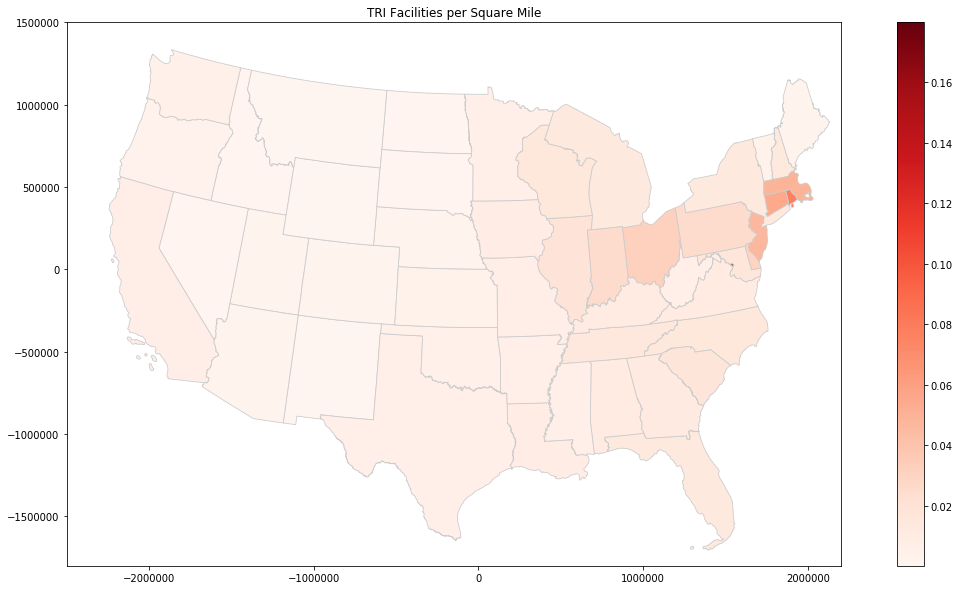

In [19]:
# map TRI sites per square mile
variable = 'TRI_DENSITY'

# project layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

vmin, vmax = states['TRI_DENSITY'].min(), states['TRI_DENSITY'].max()

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.set(
    xlim=(-2500000,2200000), ylim=(-1800000,1500000), 
    title='TRI Facilities per Square Mile');

# create legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to map
cbar = fig.colorbar(sm)

print;

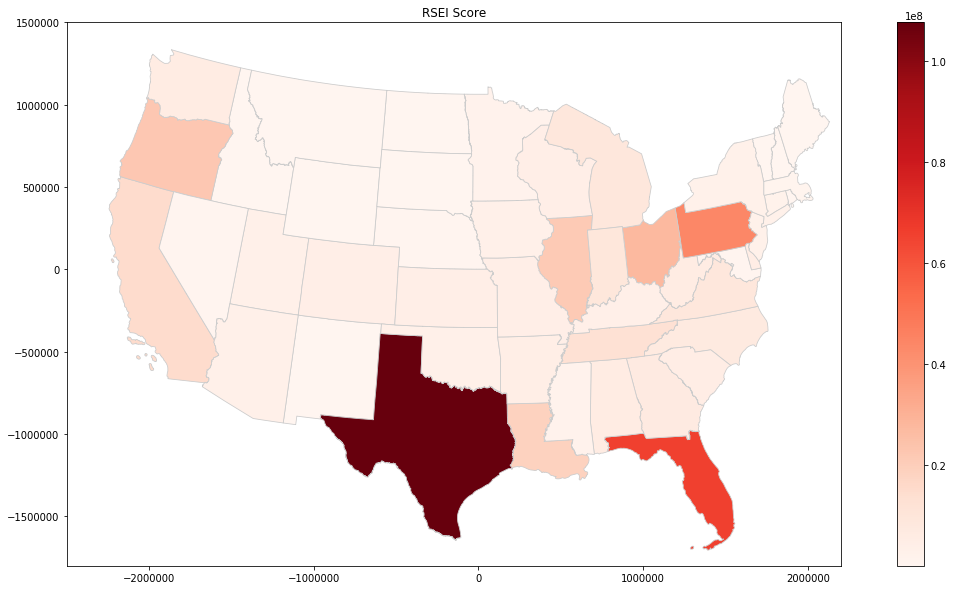

In [20]:
# map total RSEI scores by state
variable = 'RSEI_SCORE'

# project layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

vmin, vmax = states['RSEI_SCORE'].min(), states['RSEI_SCORE'].max()

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.set(
    xlim=(-2500000,2200000), ylim=(-1800000,1500000), 
    title='RSEI Score');

# create legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to map
cbar = fig.colorbar(sm)

print;

These maps indicate that TRI facilities are more concentrated in the northeast, but the higher RSEI scores are in Texas, Florida, and then Connecticut. This is a good starting point but I don't think looking at concetrations by state are really that telling. A hexgrid might be a better way to visualize this.